# Longitudinal Plane and Instability Simulation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xpart as xp
import xtrack as xt
import xwakes as xw

%config InlineBackend.figure_format = "retina"

### Load Machine and Twiss

In [2]:
# Import in Xsuite
env = xt.Environment.from_json("pimm.json")
env.vars.load_json("pimm_strengths.json")

line = env.ring
line.configure_bend_model(num_multipole_kicks=5)
twiss4d = line.twiss(method="4d")

Loading line from dict:   0%|          | 0/148 [00:00<?, ?it/s]

Done loading line from dict.           


In [3]:
# Insert horizontal aperture limitation to see losses
line.discard_tracker()
line.append_element(name="aperture", element=xt.LimitRect(min_x=-0.05, max_x=0.05));

### Switch on the RF

In [4]:
# Power the RF Cavity's variables
env.vars["vrf"] = 10e3  # 10kV
env.vars["frf"] = 1 / twiss4d.T_rev0  # h=1

In [5]:
# Now perform a 6D Twiss
twiss0 = line.twiss()
twiss0.qs

np.float64(0.001333277913701747)

## Inspect longitudinal phase space

In [6]:
# Track a set of particles with different momenta
p = line.build_particles(delta=np.linspace(-1e-2, 1e-2, 101))
line.track(p, num_turns=1500, turn_by_turn_monitor=True, with_progress=True)
mon = line.record_last_track

Tracking:   0%|          | 0/1500 [00:00<?, ?it/s]

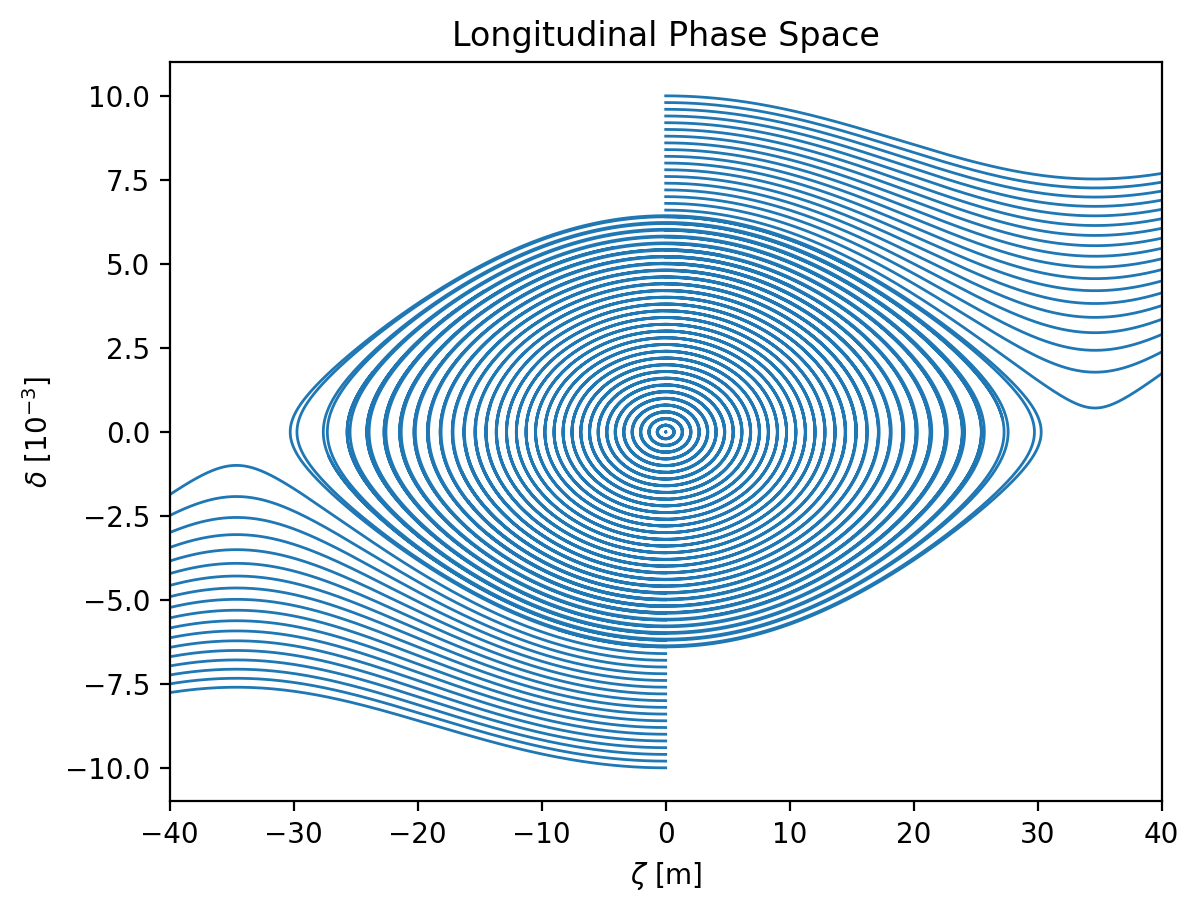

In [7]:
plt.figure()
plt.plot(mon.zeta.T, mon.delta.T * 1e3, c="C0", lw=1)
plt.xlim(-40, 40)
plt.xlabel(r"$\zeta$ [m]")
plt.ylabel(r"$\delta$ [10$^{-3}$]")
plt.title("Longitudinal Phase Space")
plt.show()

## Install Transverse Wakefields

In [8]:
# Install a resonator wakefield to represent the impedance in the line
wakefield = xw.WakeResonator(kind="dipolar_x", r=100e6, f_r=1.3e6, q=1.0)  # Shunt impedance
wakefield.configure_for_tracking(zeta_range=(-20, 20), num_slices=20)
line.append("wf", wakefield)

### Generate a Bunch Matched to the Bucket and Optics

In [9]:
%%capture
line.build_tracker()

bunch = xp.generate_matched_gaussian_bunch(
    line=line,
    num_particles=1000,
    total_intensity_particles=1e11,
    nemitt_x=2e-6,
    nemitt_y=2e-6,
    sigma_z=10.0,
)
bunch.circumference = twiss0.circumference  # required by xwakes

In [10]:
# Apply an initial kick of 1 mm
bunch.x += 1e-3

# Keep initial state
bunch0 = bunch.copy()

### Simulate 1000 Turns

In [11]:
# Define quantities to be logged during tracking
def compute_x_mean(line: xt.Line, particles: xt.Particles) -> float:
    bunch.hide_lost_particles()
    x_average = np.mean(particles.x)
    bunch.unhide_lost_particles()
    return x_average


def compute_intensity(line: xt.Line, particles: xt.Particles) -> float:
    bunch.hide_lost_particles()
    intensity = np.sum(particles.weight)
    bunch.unhide_lost_particles()
    return intensity


# Create a logger to compute these at each turn
track_log = xt.Log(x_mean=compute_x_mean, intensity=compute_intensity)

In [12]:
# Track!
line.enable_time_dependent_vars = True
line.track(bunch, log=track_log, num_turns=1000, with_progress=True)

Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/felixsoubelet/.miniforge/envs/xsuite/lib' ignored


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/felixsoubelet/.miniforge/envs/xsuite/lib' ignored


Done compiling ContextCpu kernels.


TypeError: can't multiply sequence by non-int of type 'float'

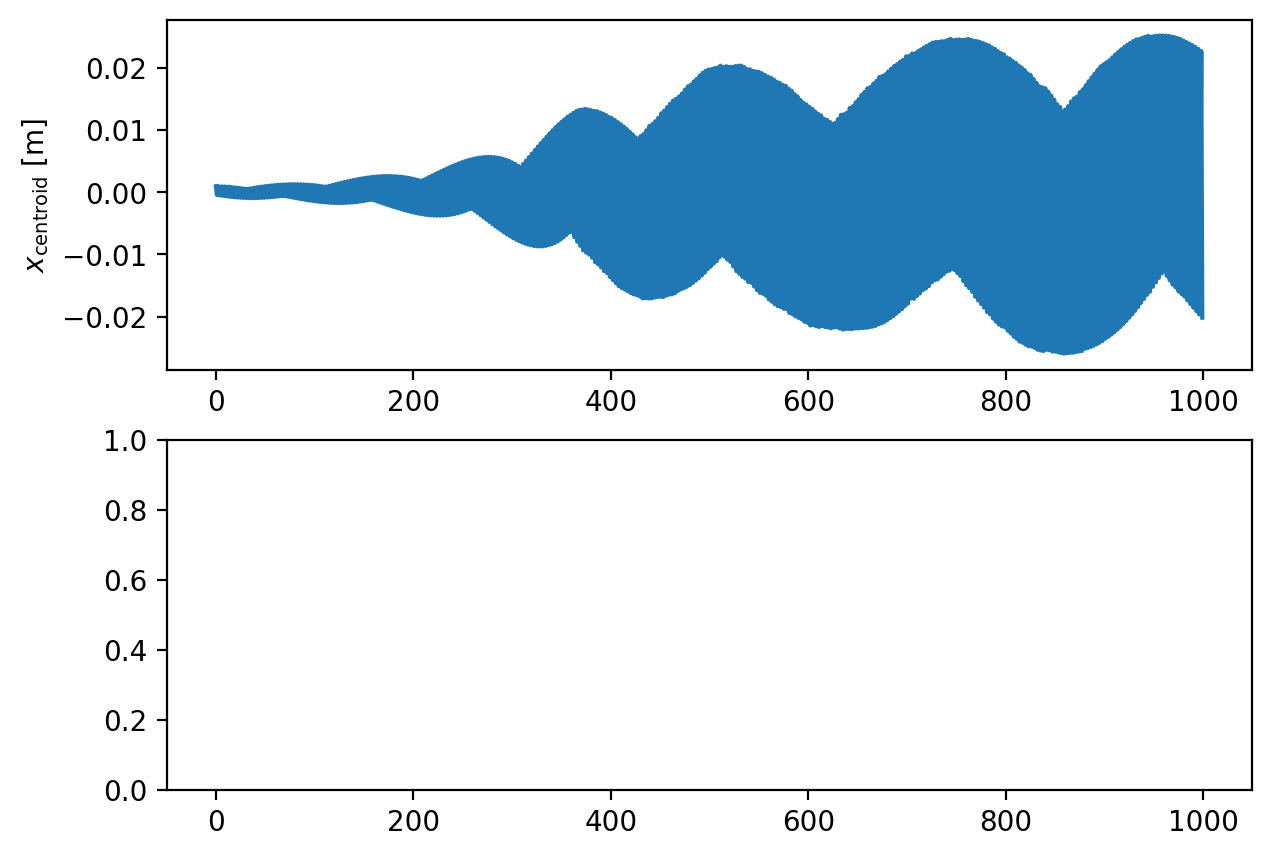

In [13]:
# Plot logged data
x_mean = line.log_last_track["x_mean"]
intensity = line.log_last_track["intensity"]

plt.figure(figsize=(7, 5))
ax1 = plt.subplot(2, 1, 1)
ax1.plot(x_mean, label=rf"$Q_x^' = {twiss0.dqx:.2f}, Q_y^' = {twiss0.dqy:.2f}$")
ax1.set_ylabel(r"$x_{\mathrm{centroid}}$ [m]")

ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(intensity * 1e-11, label=rf"$Q_x^' = {twiss0.dqx:.2f}, Q_y^' = {twiss0.dqy:.2f}$")
ax2.set_ylim(bottom=0)
ax2.set_ylabel("Intensity [$10^{11}$ppb]")
ax2.set_xlabel("Turn")

plt.gcf().align_ylabels((ax1, ax2))
ax1.legend(ncols=2, loc="lower center", bbox_to_anchor=(0.5, 1))
plt.subplots_adjust(left=0.2, hspace=0.3, top=0.9)
plt.show()

### Adjust the Sextupoles to Change the Chromaticity

In [ ]:
%%capture
line.enable_time_dependent_vars = False
opt = line.match(
    solve=False,
    method="4d",
    vary=xt.VaryList(["ksf", "ksd"], step=1e-3),
    targets=xt.TargetSet(dqx=-4.0, dqy=-4.0, tol=1e-3, tag="chrom"),
)
opt.solve()
twiss1 = line.twiss()

### Repeat the Simulation

In [ ]:
bunch = bunch0.copy()

In [ ]:
bunch.x += 1e-3
line.enable_time_dependent_vars = True
line.track(bunch, log=track_log, num_turns=1000, with_progress=True)

In [ ]:
# Plot logged data
x_mean_corr = line.log_last_track["x_mean"]
intensity_corr = line.log_last_track["intensity"]

plt.figure(figsize=(7, 5))
ax1 = plt.subplot(2, 1, 1)
ax1.plot(x_mean, label=rf"$Q_x^' = {twiss0.dqx:.2f}, Q_y^' = {twiss0.dqy:.2f}$")
ax1.plot(x_mean_corr, label=rf"$Q_x^' = {twiss1.dqx:.2f}, Q_y^' = {twiss1.dqy:.2f}$")
ax1.set_ylabel(r"$x_{\mathrm{centroid}}$ [m]")

ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(intensity * 1e-11, label=rf"$Q_x^' = {twiss0.dqx:.2f}, Q_y^' = {twiss0.dqy:.2f}$")
ax2.plot(intensity_corr * 1e-11, label=rf"$Q_x^' = {twiss1.dqx:.2f}, Q_y^' = {twiss1.dqy:.2f}$")
ax2.set_ylim(bottom=0)
ax2.set_ylabel("Intensity [$10^{11}$ppb]")
ax2.set_xlabel("Turn")

plt.subplots_adjust(left=0.2, hspace=0.3, top=0.9)
ax1.legend(ncols=2, loc="lower center", bbox_to_anchor=(0.5, 1))
plt.show()

---